1      338.915161
10     290.700928
16     259.820892
27     289.814636
28     210.851044
33     223.831543
34     273.781311
40     223.048645
49     162.990616
53     223.364746
56     275.525635
66     300.344086
71     283.439087
76     195.447800
82     238.928452
83     204.609222
84     142.499771
86     173.201370
94     151.370621
97      41.589027
98      26.912893
104    129.358505
106    250.865723
110    150.401855
111    124.514175
114     79.826668
115    335.157440
117    236.290314
123    293.516998
125    190.974777
131    264.454834
143    202.273560
145    262.224792
149    231.229736
150    237.668594
153    129.103180
158    290.555298
160    247.795395
164    160.539948
165    287.434082
172    183.926804
173    384.287720
174    205.814667
177    223.328339
178    236.026154
183    296.270874
185    332.565216
Name: dists, dtype: float32


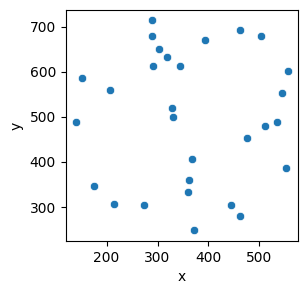

(29, 14)
(29, 151, 31, 31)


In [217]:
# REAL DATA
import pandas as pd
from tifffile import imread
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/combined/'
locs_path = data_dir + 'locs.hdf'
stacks_path = data_dir + 'stacks.ome.tif'

n_psfs = 3
real_df = pd.read_hdf(locs_path, key='locs')
real_stacks = imread(stacks_path)

centre = np.array([[real_df['x'].mean(), real_df['y'].mean()]])
pos = real_df[['x', 'y']].to_numpy()
real_df['dists'] = euclidean_distances(pos, centre).squeeze()
print(real_df['dists'])
idx = np.where(real_df['dists'] < 250)[0]
real_df = real_df.iloc[idx]
real_stacks = real_stacks[idx]


sns.scatterplot(data=real_df, x='x', y='y')
plt.show()

print(real_df.shape)
print(real_stacks.shape)

# offsets = [0,2,3]
# for i, offset in enumerate(offsets):
#     real_stacks[i] = np.roll(real_stacks[0], shift=offset, axis=0)


2.4868068833652006


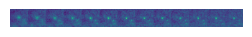

2.36318407960199


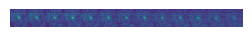

2.3554028732042473


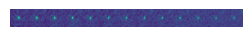

2.3279972752043596


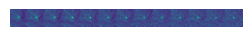

4.264174454828661


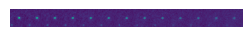

2.171280915466962


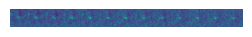

2.195604395604396


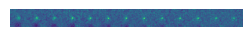

2.473068893528184


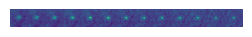

2.0223199188366587


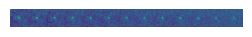

2.2585865257595774


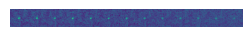

2.254080282311425


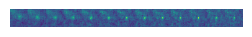

3.530591775325978


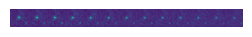

4.288487738419619


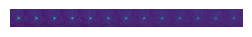

2.3050068902158936


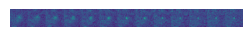

2.1205702647657843


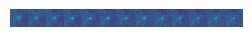

2.1140322050607954


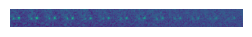

4.64021164021164


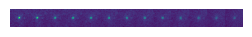

2.112551159618008


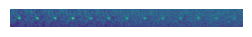

2.264021365890881


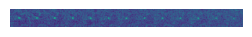

2.0248129184718393


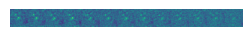

6.007530717399921


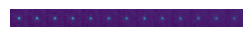

2.5049279757391965


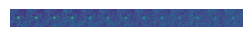

3.6518235793044953


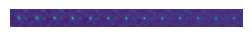

2.2932361279870395


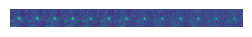

2.1347130027333074


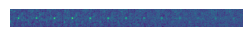

2.2644865174985656


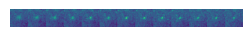

2.6672640382317803


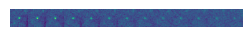

2.010974539069359


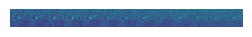

2.7713088029809034


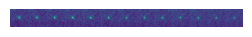

In [218]:
for psf in real_stacks:
    print(psf.max() / np.median(psf))
    show_psf_axial(psf)

In [219]:
def norm_img(img):
    return img / img.sum()

def norm_stack(stack):
    func = np.vectorize(norm_img, signature='(n)->(n)')
    return func(stack)

real_stacks = np.stack([norm_stack(s) for s in real_stacks])

In [220]:
# subpixel precision
from skimage.registration import phase_cross_correlation

def phase_align_image(img, target):
    img = norm_zero_one(img.copy())
    target = norm_zero_one(target.copy())

    shift, error, diffphase = phase_cross_correlation(img, target, return_error='always', upsample_factor=100)
    
    shift[[1, 2]] = 0
    return -shift[0]



In [221]:

DEBUG = False
UPSCALE_RATIO = 10


def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2).astype(int)

    mask = dist_from_center <= radius
    return mask

def mask_img_stack(stack, radius):
    mask = create_circular_mask(stack.shape[1], stack.shape[2], radius=radius)
    for i in range(stack.shape[0]):
        stack[i][~mask] = 0
    return stack



def norm_zero_one(s):
    max_s = s.max()
    min_s = s.min()
    return (s - min_s) / (max_s - min_s)

def pad_and_fit_spline(coords, psf, z, z_ups):
    x, y = coords
    zs = psf[:, x, y]
    cs = UnivariateSpline(z, zs, k=3, s=1e-1)
    # if max(cs(z_ups)) > 2:
    #     plt.plot(z, zs, label='raw')
    #     plt.plot(z_ups, cs(z_ups), '.', label='smooth')
    #     plt.legend()
    #     plt.show()
    return x, y, cs(z_ups)
    
def upsample_psf(psf, ratio=UPSCALE_RATIO):
    pad_width = 10
    z = np.arange(-pad_width, psf.shape[0] + pad_width)
    z_ups = np.arange(0, psf.shape[0], 1/ratio)
    upsampled_psf = np.zeros((z_ups.shape[0], *psf.shape[1:]))
    
    psf = np.pad(psf, ((pad_width, pad_width), (0, 0), (0, 0)), mode='edge')
    xys = list(product(np.arange(psf.shape[1]), np.arange(psf.shape[2])))
    func = partial(pad_and_fit_spline, psf=psf, z=z, z_ups=z_ups)
    res = list(map(func, xys))
    # with Pool(8) as p:
    #     res = list(p.imap(func, xys))
    for x, y, z_col in res:
        upsampled_psf[:, x, y] = z_col

    return upsampled_psf

def pad_psf(psf):
    return np.pad(psf, ((20, 20), (0, 0), (0, 0)), mode='edge')

def plot_correction(target, img, best_i, errors):

    psf_corrected = np.roll(img, int(best_i), axis=0)
    plt.plot(target.max(axis=(1,2)), label='target')
    plt.plot(img.max(axis=(1,2)),  label='original')
    plt.plot(psf_corrected.max(axis=(1,2)), label='corrected', )

    plt.legend()
    plt.show()

def tf_find_optimal_roll(target, img, upscale_ratio=UPSCALE_RATIO):
    ref_tf = tf.convert_to_tensor(target)
    img_tf = tf.convert_to_tensor(img)
    errors = []

    for i in range(img.shape[0]):
        error = tf.reduce_mean(mse(ref_tf, img_tf))
        errors.append(error)
        img_tf = tf.roll(img_tf, 1, axis=0)

    best_i = tf.argmin(errors).numpy()
    # Prefer small backwards roll to large forwards roll
    if abs(best_i - img.shape[0]) < best_i:
        best_i = best_i - img.shape[0]

    if DEBUG:
        plot_correction(target, img, best_i, errors)

    return best_i/upscale_ratio

In [222]:

offsets = np.array([phase_align_image(psf, real_stacks[0]) for psf in real_stacks])
print(offsets)
offsets2 = np.array([tf_find_optimal_roll(psf, real_stacks[0]) for psf in real_stacks])
print(offsets2)


[ -0.    17.69 -14.8  -51.11 -13.97  -1.09 -39.89  17.11 -34.22 -30.1
  39.29  27.1   66.15 -21.02  26.96 -66.85 -47.94  22.01  62.06 -55.72
 -57.07  -4.03   4.66  20.02 -32.95 -63.95 -60.08 -25.12  19.1 ]
[ 0.  -0.2 -1.6 -0.1 -1.4  0.1 -0.5  1.  -1.1 -3.   0.6 -0.4 -3.8  0.3
 -0.3 -2.6 -2.5 -3.4 -1.9 -3.  -3.5 -1.1 -0.5 -1.9 -2.7  0.5 -2.8 -1.8
 -0.2]


<AxesSubplot:xlabel='x', ylabel='y'>

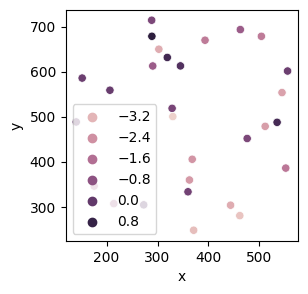

In [223]:
sns.scatterplot(data=real_df, x='x', y='y', hue=offsets2)

In [206]:
def gen_zs(psf, offset):
    return np.arange(psf.shape[0]) + offset

zs = np.array([gen_zs(psf, offset) for psf, offset in zip(real_stacks, offsets)])

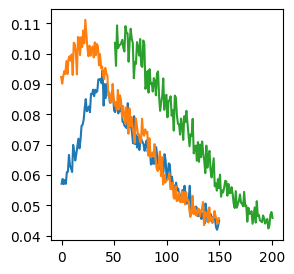

-0.0


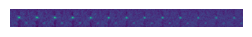

-0.41000000000000003


TypeError: slice indices must be integers or None or have an __index__ method

In [212]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import seaborn as sns
plt.rcParams['figure.figsize'] = [3, 3]
for stack, z in zip(real_stacks, zs):
    stack = norm_stack(stack)
    plt.plot(z, stack.max(axis=(-1,-2)))
plt.show()

for stack, o in zip(real_stacks, offsets):
    s = np.roll(stack, o, axis=0)
    show_psf_axial(s)


In [196]:
from sklearn.metrics import mean_squared_error

z_coords_base = np.arange(real_stacks.shape[1])
all_z_coords = []
plt.rcParams['figure.figsize'] = [5, 5]
for i, offsets in enumerate(list(real_df['offsets'])):
    z_coords = z_coords_base-offsets
    all_z_coords.append(z_coords)
    ys = real_stacks[i].max(axis=(1,2))
    ys = norm_zero_one(ys)
    plt.plot(z_coords, ys)
plt.show()
all_z_coords = np.array(all_z_coords).flatten()
all_psfs = real_stacks.reshape((-1, *real_stacks.shape[2:]))
print(all_z_coords.shape)
print(all_psfs.shape)

plt.rcParams['figure.figsize'] = [30, 30]

idx = np.argsort(all_z_coords)
plt.imshow(grid_psfs(all_psfs[idx]))
plt.show()

KeyError: 'offsets'

In [11]:
import numpy as np
from skimage.exposure import match_histograms
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from multiprocessing import Pool
from itertools import product
from functools import partial
import tqdm
from keras.losses import MeanSquaredError
from multiprocessing.spawn import prepare
import numpy as np
from scipy.interpolate import UnivariateSpline
from tqdm import trange
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/miguel/Projects/uni/phd/smlm_z')
from data.estimate_offset import get_peak_sharpness
from data.visualise import grid_psfs, show_psf_axial


mse = MeanSquaredError()

DEBUG = False
UPSCALE_RATIO = 10



def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2).astype(int)

    mask = dist_from_center <= radius
    return mask

def mask_img_stack(stack, radius):
    mask = create_circular_mask(stack.shape[1], stack.shape[2], radius=radius)
    for i in range(stack.shape[0]):
        stack[i][~mask] = 0
    return stack


def norm_zero_one(s):
    max_s = s.max()
    min_s = s.min()
    return (s - min_s) / (max_s - min_s)

def pad_and_fit_spline(coords, psf, z, z_ups):
    x, y = coords
    zs = psf[:, x, y]
    cs = UnivariateSpline(z, zs, k=3, s=1e-1)
    # if max(cs(z_ups)) > 2:
    #     plt.plot(z, zs, label='raw')
    #     plt.plot(z_ups, cs(z_ups), '.', label='smooth')
    #     plt.legend()
    #     plt.show()
    return x, y, cs(z_ups)
    
def upsample_psf(psf, ratio=UPSCALE_RATIO):
    pad_width = 10
    z = np.arange(-pad_width, psf.shape[0] + pad_width)
    z_ups = np.arange(0, psf.shape[0], 1/ratio)
    upsampled_psf = np.zeros((z_ups.shape[0], *psf.shape[1:]))
    
    psf = np.pad(psf, ((pad_width, pad_width), (0, 0), (0, 0)), mode='edge')
    xys = list(product(np.arange(psf.shape[1]), np.arange(psf.shape[2])))
    func = partial(pad_and_fit_spline, psf=psf, z=z, z_ups=z_ups)
    res = list(map(func, xys))
    # with Pool(8) as p:
    #     res = list(p.imap(func, xys))
    for x, y, z_col in res:
        upsampled_psf[:, x, y] = z_col

    return upsampled_psf

def pad_psf(psf):
    return np.pad(psf, ((20, 20), (0, 0), (0, 0)), mode='edge')

def plot_correction(target, img, best_i, errors):

    psf_corrected = np.roll(img, int(best_i), axis=0)
    plt.plot(target.max(axis=(1,2)), label='target')
    plt.plot(img.max(axis=(1,2)),  label='original')
    plt.plot(psf_corrected.max(axis=(1,2)), label='corrected', )

    plt.legend()
    plt.show()

def tf_find_optimal_roll(target, img, upscale_ratio=UPSCALE_RATIO):
    ref_tf = tf.convert_to_tensor(target)
    img_tf = tf.convert_to_tensor(img)
    errors = []

    for i in range(img.shape[0]):
        error = tf.reduce_mean(mse(ref_tf, img_tf))
        errors.append(error)
        img_tf = tf.roll(img_tf, 1, axis=0)

    best_i = tf.argmin(errors).numpy()
    # Prefer small backwards roll to large forwards roll
    if abs(best_i - img.shape[0]) < best_i:
        best_i = best_i - img.shape[0]

    if DEBUG:
        plot_correction(target, img, best_i, errors)

    return best_i/upscale_ratio


def find_seed_psf(df):
    # Seed PSF - most centered PSF in FOV
    center = df[['x', 'y']].mean(axis=0).to_numpy()
    coords = df[['x', 'y']].to_numpy()
    dists = euclidean_distances([center], coords).squeeze()
    first_point = np.argmin(dists)
    return first_point

import numpy as np
import scipy.optimize as opt
import skimage.filters as filters
from tqdm import trange


def measure_psf_fwhm(psf):
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-(x - mean) ** 2 / (2 * stddev ** 2))
    # Normalize the PSF to range [0, 1]
    psf_norm = (psf - np.min(psf)) / (np.max(psf) - np.min(psf))
    
    # Find the center of the PSF using the maximum intensity
    center = np.unravel_index(np.argmax(psf_norm), psf_norm.shape)
    # Extract a 1D slice of the PSF along the z-axis passing through the center
    z_slice = psf_norm[:, center[0]]
    
    # Estimate the initial parameters of the Gaussian fit
    amplitude = np.max(z_slice) - np.min(z_slice)
    mean = center[0]
    stddev = 2
    
    # Fit the Gaussian to the 1D slice using least squares optimization
    popt, _ = opt.curve_fit(gaussian, np.arange(z_slice.size), z_slice, p0=[amplitude, mean, stddev])
    
    # Compute the FWHM of the Gaussian fit
    fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]
    
    return fwhm

from skimage.filters import gaussian
def prepare_psf(psf):
    psf = gaussian(psf, sigma=1)
    psf = norm_zero_one(psf.copy())
    psf = pad_psf(psf)
    psf = upsample_psf(psf)
    psf = mask_img_stack(psf, 12)
    return psf


    
def classic_align_psfs(psfs, df):
    seed_psf = find_seed_psf(df)
    ref_psf = psfs[seed_psf]
    offsets = np.zeros((psfs.shape[0]))

    ref_0 = get_peak_sharpness(psfs[seed_psf])

    for i in trange(0, psfs.shape[0]):
        psf = psfs[i]
        psf = prepare_psf(psf)
        psf = match_histograms(psf, ref_psf)
        offsets[i] = -tf_find_optimal_roll(ref_psf, psf)
        if DEBUG:
            offset_psf = np.roll(psf, shift=-int(offsets[i]), axis=0)
            imgs = np.concatenate((ref_psf, offset_psf), axis=2)
            show_psf_axial(imgs, subsample_n=30)

#     offsets -= ref_0

    return offsets




classic_align_psfs(real_stacks, real_df)

# print(-tf_find_optimal_roll(real_stacks[0], real_stacks[1]))
# psf1 = prepare_psf(psfs[i])
# psf2 = prepare_psf(psfs[aligner.seed_idx])

# print(-tf_find_optimal_roll(psf1, psf2))
# aligner = ClassicAligner(df, denoised_psfs, n_paths=10)
# median, var = aligner.find_offset(i)
# print(aligner.pairwise_offset.cache_info())
# plt.show()

# z_pred = []
# z_true = df['roll'] - df['roll'].min()
# for i in trange(df.shape[0]):
#     z_pred.append(aligner.find_offset(i)[0])
# z_pred = np.array(z_pred)
# z_pred -= z_pred.min()

# from sklearn.metrics import mean_absolute_error
# error = mean_absolute_error(z_pred, z_true)
# bestfit_error(z_true, z_pred)
# print(error)


# z_old_pred = []
# for i in trange(df.shape[0]):
#     z_old_pred.append(aligner.pairwise_offset(i, aligner.seed_idx))
# bestfit_error(z_true, z_old_pred)
# error = mean_absolute_error(z_old_pred, z_true)
# print(error)

  0%|                                                                                                                               | 0/3 [00:00<?, ?it/s]2023-06-05 15:00:39.382286: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: required broadcastable shapes



InvalidArgumentError: {{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:SquaredDifference]